# 🧠 Mastering LLM Fine-Tuning with TRL – Supervised Fine-Tuning

Welcome! This notebook is part of a tutorial series where you'll learn how to fine-tune Large Language Models (LLMs) using 🤗 TRL.
We introduce key concepts, set up the required tools, and use techniques like Supervised Fine-Tuning (SFT) and Group-Relative Policy Optimization (GRPO).

## 📋 Prerequisites

Before you begin, make sure you have the following:

* A working knowledge of Python and PyTorch
* A basic understanding of machine learning and deep learning concepts
* Access to a GPU accelerator – this notebook is designed to run with **at least 16GB of GPU memory**, such as what is available for free on [Google Colab](https://colab.research.google.com)
* The `trl` library installed – this tutorial has been tested with **TRL version 0.17**
  If you don’t have `trl` installed yet, you can install it by running the following code block:

In [1]:
%pip install trl

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.0
    Uninstalling fsspec-2025.5.0:
      Successfully uninstalled fsspec-2025.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lighteval 0.8.1.dev0 requires GitPython>=3.1.41, but you have gitpython 3.1.18 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


* A [Hugging Face account](https://huggingface.co) with a configured access token. If needed, run the following code.
This will prompt you to enter your Hugging Face access token. You can generate one from your Hugging Face account settings under [Access Tokens](https://huggingface.co/settings/tokens). The token must have `Write access to contents/settings of all repos under your personal namespace`

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## 🔄 Quick Recap of the Last Session

In the previous session, we explored the foundational concepts behind training and fine-tuning Large Language Models (LLMs). Here's a brief summary:

* LLMs operate on sequences of integers known as *tokens*. Given a sequence, they predict the probability distribution of the next token in the sequence.
* The first phase of training an LLM is called **pretraining**. This involves training the model on a massive corpus of unlabeled text data.
* The output of pretraining is a **base model**, which has learned general language patterns but isn’t specialized for specific tasks.
* To adapt the base model for a particular use case—like building a chatbot—we need to **fine-tune** (or post-train) it on a dataset of conversations.
* Many high-quality conversational datasets are available publicly on the [Hugging Face Hub](https://huggingface.co/datasets).
* These datasets are often not in a format that's directly usable for training, so **data preprocessing** is usually required.

Now that we're on the same page, let's dive into the next session! First Let's load our base model and tokenizer. 


We'll be using a different model from the first session: `SmolLM2-360M`.


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-360M")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-360M", device_map="auto")

As before, let's define a chat template and make the necessary modifications to the template and tokenizer.

In [4]:
tokenizer.chat_template = """{{- '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n' }}
{%- for message in messages %}
    {{- '<|im_start|>' + message.role + '\n' + message.content + '<|im_end|>' + '\n' }}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|im_start|>assistant\n' }}
{%- endif %}"""
tokenizer.eos_token = "<|im_end|>"
model.config.eos_token_id = tokenizer.eos_token_id
model.generation_config.eos_token_id = tokenizer.eos_token_id

Remember, configuring a chat template doesn't make the model capable of chatting.
It only gives the ability to format inputs in a dialogue structure; the model still needs to be fine-tuned on conversational data to respond like a chatbot.

In [5]:
from transformers import pipeline

pipeline = pipeline(task="text-generation", model=model, tokenizer=tokenizer)

question = "What does it mean for a matrix to be invertible?"
prompt = [{"role": "user", "content": question}]
pipeline(prompt, max_new_tokens=50)[0]["generated_text"]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'role': 'user',
  'content': 'What does it mean for a matrix to be invertible?'},
 {'role': 'assistant',
  'content': 'What does it mean for a matrix to be invertible?��boutiqueassistant\nWhat does it mean for a matrix to be invertible?��boutiqueassistant\nWhat does it mean for a matrix to be invertible?'}]

To make the exercise more engaging, we'll use a custom dataset I've created especially for you. Instead of the usual back-and-forth between a lazy user and a helpful assistant, I've spiced things up with dialogues between Rick and Morty. If this reference doesn't ring a bell - sorry for you!

So what we're going to do is basically train a Rick to respond to Morty.

![](https://cdn-uploads.huggingface.co/production/uploads/631ce4b244503b72277fc89f/m9fHggYpFjil8L55a3UNt.png)

In [6]:
from datasets import load_dataset

dataset = load_dataset("qgallouedec/rick-science", split="train")
dataset[0]

{'question': 'How does the velocity of a car change if it accelerates uniformly from rest with an acceleration of 2 m/s² for 5 seconds?',
 'reasoning': "Alright, let's dissect this snooze-fest of a question. Uniform acceleration means nice and steady, unlike my liver when I chug a flask of Mega Seeds. Starting from rest, so initial velocity is zero. Geez, way to state the obvious. I swear, if someone explains 'rest' one more time, I'm gonna lose my mind. So, we've got this precious little acceleration of 2 m/s² — what, did it get scared of the bigger numbers? Multiply that by the 5 seconds it manages to accelerate without falling apart, and we get the final velocity. It's a simple product of time and acceleration. Velocity = acceleration × time, blah, blah, blah. It's basic physics, but apparently, the geniuses of the Universe need me to hold their hand through it.",
 'answer': "Okay, Morty! Listen up, 'cause I'm only saying this once, alright? Your precious car goes from 'sitting-on-i

Similarly, you can see that the dataset needs to be pre-formatted. So, as before, we write and apply the function to format the dataset.

In [7]:
def to_conversation(example):
    return {
        "messages": [
            {"role": "user", "content": example["question"]},
            {"role": "assistant", "content": f"<think>{example['reasoning']}</think> {example['answer']}"},
        ]
    }

dataset = dataset.map(to_conversation, remove_columns=dataset.column_names)
dataset[0]

Map:   0%|          | 0/1183 [00:00<?, ? examples/s]

{'messages': [{'content': 'How does the velocity of a car change if it accelerates uniformly from rest with an acceleration of 2 m/s² for 5 seconds?',
   'role': 'user'},
  {'content': "<think>Alright, let's dissect this snooze-fest of a question. Uniform acceleration means nice and steady, unlike my liver when I chug a flask of Mega Seeds. Starting from rest, so initial velocity is zero. Geez, way to state the obvious. I swear, if someone explains 'rest' one more time, I'm gonna lose my mind. So, we've got this precious little acceleration of 2 m/s² — what, did it get scared of the bigger numbers? Multiply that by the 5 seconds it manages to accelerate without falling apart, and we get the final velocity. It's a simple product of time and acceleration. Velocity = acceleration × time, blah, blah, blah. It's basic physics, but apparently, the geniuses of the Universe need me to hold their hand through it.</think> Okay, Morty! Listen up, 'cause I'm only saying this once, alright? Your pr

At this point, we have a model ready for training and a dataset ready to go. This is where TRL comes in—it provides the `SFTTrainer`, a trainer designed to fine-tune the model using the dataset.

**But what is SFT?**


## 🕵️ Supervised Fine-Tuning (SFT)

SFT stands for **Supervised Fine-Tuning**. There’s nothing particularly revolutionary about the SFT method. It’s simply training the model to predict the next token in a supervised way. Just like in pretraining, we minimize the cross-entropy loss between the model’s predicted distribution and the actual next token. The key difference is that, in SFT, the model is trained on **curated**, labeled data — often conversational or instruction-following examples.

I'm going to break from the usual approach and show you the training process *before* diving into the explanation. Why?

1. You'll get an immediate feel for what the training actually does.
2. The training can run in the background while I walk you through what's happening.

Without explanation, here's the training code block.

In [8]:
from trl import SFTTrainer, SFTConfig

args = SFTConfig(
    output_dir="data/SmolLM2-360M-Rickified",
    gradient_checkpointing=True,
    bf16=True,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    # max_length=181,
    # num_train_epochs=1,
    logging_steps=10,
    run_name="SmolLM2-360M-Rickified",
)

trainer = SFTTrainer(
    model=model,
    args=args,
    processing_class=tokenizer,
    train_dataset=dataset,
)

Converting train dataset to ChatML:   0%|          | 0/1183 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1183 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1183 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1183 [00:00<?, ? examples/s]

[2025-05-21 02:04:17,209] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda-12.1/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda-12.1/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/fsx/qgallouedec/miniconda3/envs/trl/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/fsx/qgallouedec/minic

In [9]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: qgallouedec (huggingface) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,3.093200
20,2.763500
30,2.563000
40,2.399700
50,2.310400
60,2.321600
70,2.267700
80,2.211500
90,2.180100
100,2.189600


TrainOutput(global_step=222, training_loss=2.261591419443354, metrics={'train_runtime': 158.4299, 'train_samples_per_second': 22.401, 'train_steps_per_second': 1.401, 'total_flos': 3468658635446400.0, 'train_loss': 2.261591419443354})

It's very important to remember that what training LLM, VRAM is the backbone of the battle. This is especially important in our case, as we’re working with limited compute resources. I designed this notebook to be runnable on the free version of Colab, which only provide a GPUs with 16GB of memory. As a result, we must manage GPU memory carefully to avoid running out. This constraint also presents a valuable opportunity to learn about GPU memory usage and optimization—skills that are essential when training large language models (LLMs).

### 🥛 What consumes GPU memory?

When you profile GPU memory usage during training, you get a chart like this one:

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/train_memory/colorized_training_profile.png)

As shown in the graph, several components occupy GPU memory:

* **Model**: The neural network itself, loaded into memory.
* **Optimizer**: This usually takes up twice as much memory as the model.
* **Activations**: These are the intermediate outputs from each layer during the forward pass.
* **Gradients**: The derivatives of the loss with respect to the activations, used during backpropagation.
* **Optimizer states**: Temporary variables needed by the optimizer during training.

### 🤏 Use a smaller model

You might have noticed that base models are often released in multiple sizes. Larger models tend to perform better, but they also consume significantly more memory. Choosing a smaller model is the most impactful optimization you can make—it reduces not just the model size, but also the memory used by the optimizer and activations.

For this notebook, we’ll be using `SmolLM2-360M`.

### 📐 Handle the sequence length carefully

The memory required for activations is directly proportional to the number of tokens in a batch. The number of tokens in a batch, in turn, depends on two factors: the *batch size* and the *sequence length*. Doubling the sequence length will double the memory needed for activations, and similarly, doubling the batch size will also double the memory required for activations.

![](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/why_you_should_truncate.png)

And remember, whether you hit an Out Of Memory (OOM) error only depends on the longest sequence in the entire dataset. If, at some point during training, you encounter a sequence longer than what the GPU can handle, you'll get an OOM error, and the training will need to be restarted from scratch. So, it's important to control this maximum sequence length, and truncate any sequences that exceed it.

To get a better sense of what could be a reasonable value for the maximum sequence length, you can check the distribution of sequence lengths in your dataset. You can do this by running the following code:

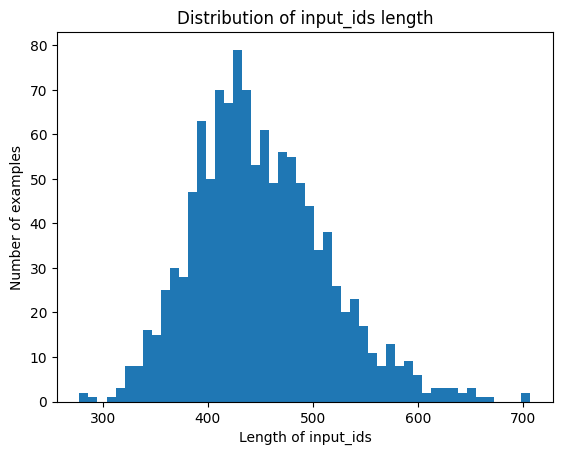

In [10]:
import matplotlib.pyplot as plt

input_ids = [tokenizer.apply_chat_template(example["messages"]) for example in dataset]
lens = [len(ids) for ids in input_ids]

plt.hist(lens, bins=50)
plt.xlabel("Length of input_ids")
plt.ylabel("Number of examples")
plt.title("Distribution of input_ids length")
plt.show()

### Handle the batch size carefully

As explained earlier, batch size directly impacts activation memory. But there's a tradeoff: larger batch sizes generally lead to more stable training.

To balance memory constraints with training quality, you can use gradient accumulation—a technique that simulates a larger batch size by accumulating gradients over multiple smaller batches. For example, all of the following configurations result in the same effective batch size (16):

```python
from trl import SFTConfig

training_args = SFTConfig(per_device_train_batch_size=16, gradient_accumulation_steps=1, ...)  # fast but memory intensive
training_args = SFTConfig(per_device_train_batch_size=8, gradient_accumulation_steps=2, ...)
training_args = SFTConfig(per_device_train_batch_size=4, gradient_accumulation_steps=4, ...)
training_args = SFTConfig(per_device_train_batch_size=2, gradient_accumulation_steps=8, ...)
training_args = SFTConfig(per_device_train_batch_size=1, gradient_accumulation_steps=16, ...)  # slow but memory efficient
```

Just note: more accumulation steps mean more forward passes per update, which increases training time. When possible, prefer fewer steps with a larger batch size.



### 🕰 Use gradient checkpointing

Gradient checkpointing is a memory-saving technique that reduces GPU usage during training by selectively storing only some intermediate activations and recomputing the others during backpropagation.

![](https://github.com/cybertronai/gradient-checkpointing/raw/master/img/output.gif)

![](https://github.com/cybertronai/gradient-checkpointing/raw/master/img/output2.gif)

We won't go into the details of how it works, but remember that it can be a bit slower than the standard approach. However, it’s a great way to save memory, especially when training large models. And it's super easy to enable in the `SFTTrainer`, you just have to set the `gradient_checkpointing` argument to `True` when creating the config:

```python
from trl import SFTConfig

config = SFTConfig(gradient_checkpointing=True,  ...)
```

### 🧊 Use mixed precision

Mixed precision training speeds up training and reduces memory usage by combining 16-bit (`float16` or `bfloat16`) and 32-bit (`float32`) floating-point arithmetic. It keeps most operations in 16-bit to save memory and compute time, while using 32-bit where higher precision is needed (like loss scaling or certain model updates). This technique is especially helpful when training large models, as it allows you to fit larger batches or longer sequences in memory—often without a noticeable drop in model performance.

```python
from trl import SFTConfig

training_args = SFTConfig(bf16=True, ...)
```

## 🛸 Did rickification work?

Let's see with a basic question!

In [11]:
from transformers import pipeline

pipeline = pipeline(task="text-generation", model=trainer.model, tokenizer=trainer.processing_class)

question = "What would happen to time for an astronaut traveling near the speed of light?"
prompt = [{"role": "user", "content": question}]
pipeline(prompt, max_new_tokens=400)[0]["generated_text"]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/fsx/qgallouedec/miniconda3/envs/trl/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[{'role': 'user',
  'content': 'What would happen to time for an astronaut traveling near the speed of light?'},
 {'role': 'assistant',
  'content': "<think>Alright, let's dive into this cosmic time warp. So, we're talking about the speed of light, which is like the cosmic speed limit. It's 299,792,458 meters per second. Now, if you're traveling at that speed, you're basically zooming around the universe at warp speed. Time dilation, the Einstein-Rosen paradox, and all that jazz. Time slows down for you, like you're a cosmic time-sucking vacuum cleaner. Time dilation is the time you'd experience if you were traveling at the speed of light. It's like you're a cosmic time-sucking vacuum cleaner. Time slows down for you, like you're a cosmic time-sucking vacuum cleaner. Time dilation is the time you'd experience if you were traveling at the speed of light. It's like you're a cosmic time-sucking vacuum cleaner. Time slows down for you, like you're a cosmic time-sucking vacuum cleaner. The 

It sounds very much like Rick!
Let's try with another one, a bit out-of-distribution, to see how the model reacts.

In [12]:
question = "What is Edmonton's average temperature in January?"
prompt = [{"role": "user", "content": question}]
pipeline(prompt, max_new_tokens=400)[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'role': 'user',
  'content': "What is Edmonton's average temperature in January?"},
 {'role': 'assistant',
  'content': "<think>Alright, let's dive into this mess. Edmonton, the city of dreams, is located in the northernmost part of Canada, right smack dab in the middle of the Arctic Circle. It's a city of 1.5 million people, but it's not just any city. It's the city of the year for being the coldest city in the world. So, we're talking about a city that's 20 degrees colder than the Arctic Circle. Now, let's break down the temperature. January is the coldest month of the year, so we're looking at -30 degrees Celsius. That's -22 degrees Fahrenheit. It's like trying to find a needle in a haystack, but with a temperature of -30 degrees. It's a frigid, frigid city.</think> Morty, listen up! Edmonton's average temperature in January is -30 degrees Celsius, or -22 degrees Fahrenheit. It's like trying to find a needle in a haystack, but with a temperature of -30 degrees. It's a frigid, frig

Now that we've tested our model, it's time to share it with the world! To do so, simply push it to the Hugging Face Hub using `push_to_hub`.

In [13]:
trainer.push_to_hub(dataset_name="qgallouedec/rick-science")

  0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/qgallouedec/SmolLM2-360M-Rickified/commit/8545f71616bc0545715a83438a83b417a77a1271', commit_message='End of training', commit_description='', oid='8545f71616bc0545715a83438a83b417a77a1271', pr_url=None, repo_url=RepoUrl('https://huggingface.co/qgallouedec/SmolLM2-360M-Rickified', endpoint='https://huggingface.co', repo_type='model', repo_id='qgallouedec/SmolLM2-360M-Rickified'), pr_revision=None, pr_num=None)

Before we close this chapter, let's generate a final one, just for fun!

In [14]:
question = "A ball is thrown vertically upward with an initial speed of 12 m/s. What is its maximum height?"
prompt = [{"role": "user", "content": question}]
pipeline(prompt, max_new_tokens=400)[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/fsx/qgallouedec/miniconda3/envs/trl/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[{'role': 'user',
  'content': 'A ball is thrown vertically upward with an initial speed of 12 m/s. What is its maximum height?'},
 {'role': 'assistant',
  'content': "<think>Alright, let's dive into this cosmic mess of physics. We got a ball, thrown vertically up, with an initial speed of 12 m/s. So, we're talking about a vertical velocity of 12 m/s. Now, we're gonna need to use the Pythagorean theorem to find the height. The height is the square root of the square of the initial velocity plus the square of the vertical velocity. So, that's 12 squared plus 0 squared. That's 144. Then, we take the square root of that, and boom, we get 12.69 meters. That's the height of the ball. It's like, uh, the height of a cosmic fart.</think> Alright, Morty, listen up! You throw a ball vertically up with 12 m/s, and it's gonna go up like a rocket. It's gonna go up to 12.69 meters. That's the height of the ball. It's like, uh, the height of a cosmic fart. It's gonna go up like a rocket, Morty! It's 